In [1]:
!pip install -q statsmodels dtreeviz

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
!apt update && apt-get install -yy graphviz

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]    
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Ign:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:5 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]0m  m
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [24.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [2546 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [396 kB]
Get:12 https://developer.downl

Get:43 http://archive.ubuntu.com/ubuntu bionic/universe amd64 liblab-gamut1 amd64 2.40.1-2 [178 kB]
Get:44 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxt6 amd64 1:1.1.5-1 [160 kB]
Get:45 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxmu6 amd64 2:1.1.2-2 [46.0 kB]
Get:46 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxaw7 amd64 2:1.0.13-1 [173 kB]
Get:47 http://archive.ubuntu.com/ubuntu bionic/universe amd64 graphviz amd64 2.40.1-2 [601 kB]
Get:48 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgts-bin amd64 0.7.6+darcs121130-4 [41.3 kB]
Fetched 7489 kB in 2s (3720 kB/s)        
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libxau6:amd64.
(Reading database ... 17013 files and directories currently installed.)
Preparing to unpack .../00-libxau6_1%3a1.0.8-1ubuntu1_amd64.deb ...
Unpacking libxau6:amd64 (1:1.0.8-1ubuntu1) ...
Selecting previously unselected package libbsd0:amd64.
Preparing

Preparing to unpack .../44-libxmu6_2%3a1.1.2-2_amd64.deb ...
Unpacking libxmu6:amd64 (2:1.1.2-2) ...
Selecting previously unselected package libxaw7:amd64.
Preparing to unpack .../45-libxaw7_2%3a1.0.13-1_amd64.deb ...
Unpacking libxaw7:amd64 (2:1.0.13-1) ...
Selecting previously unselected package graphviz.
Preparing to unpack .../46-graphviz_2.40.1-2_amd64.deb ...
Unpacking graphviz (2.40.1-2) ...
Selecting previously unselected package libgts-bin.
Preparing to unpack .../47-libgts-bin_0.7.6+darcs121130-4_amd64.deb ...
Unpacking libgts-bin (0.7.6+darcs121130-4) ...
Setting up libgts-0.7-5:amd64 (0.7.6+darcs121130-4) ...
Setting up libpathplan4 (2.40.1-2) ...
Setting up liblab-gamut1 (2.40.1-2) ...
Setting up libjbig0:amd64 (2.1-3.1build1) ...
Setting up fonts-dejavu-core (2.37-1) ...
Setting up libdatrie1:amd64 (0.2.10-7) ...
Setting up libtiff5:amd64 (4.0.9-5ubuntu0.4) ...
Setting up libbsd0:amd64 (0.8.7-1ubuntu0.1) ...
Setting up fonts-liberation (1:1.07.4-7~18.04.1) ...
Setting up 

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
from joblib import dump, load

from utils import check_data_gaps, preprocess_time_series
from feature_generation import Preprocess, create_features, get_feature_names

import warnings


jtplot.style()

In [5]:
data = pd.read_csv('data/btc_2021-01-01_2021-03-06_5m.csv', index_col=['date'], parse_dates=['date'])
data = (data
        .resample(rule='5min')
        .asfreq()
        .interpolate(method='time', limit=None))

data['TR'] = np.maximum((data['High'] - data['Low']).abs(), (data['High'] - data['Close'].shift(1).abs()))
data['TR'] = np.maximum(data['TR'], (data['Low'] - data['Close'].shift(1).abs()))
data['ATR'] = data['TR'].rolling(6, min_periods=1).mean()
data['DM'] = (data['High'] - data['Low']) / data['TR'] - ( (data['High'].shift(1) - data['Low'].shift(1)) / data['TR'].shift(1) )

data['DI_plus'] = data['High'] - data['High'].shift(1)
data['DI_minus'] = data['Low'] - data['Low'].shift(1)

data['DI_plus_ind'] = data[(data['DI_plus'] > 0)
                       & (data['DI_plus'].abs() > data['DI_minus'].abs())
                      ]['DI_plus']
data['DI_plus_ind'] = data['DI_plus_ind'].fillna(0)

data['DI_minus_ind'] = -data[(data['DI_minus'] < 0)
                        & (data['DI_plus'].abs() < data['DI_minus'].abs())
                       ]['DI_minus']
data['DI_minus_ind'] = data['DI_minus_ind'].fillna(0)
data['DI_plus_ind'] = data['DI_plus_ind'].rolling(6, min_periods=1).sum() / data['TR'].rolling(6, min_periods=1).sum()
data['DI_minus_ind'] = data['DI_minus_ind'].rolling(6, min_periods=1).sum() / data['TR'].rolling(6, min_periods=1).sum()
data['DI'] = data['DI_plus_ind'] - data['DI_minus_ind']

data['MOMENTUM'] = data['Close'] - data['Close'].shift(2)

data['SUM_up_close'] = data['Close'] - data['Close'].shift(1)
data['SUM_up_close'] = data[data['SUM_up_close'] > 0]['SUM_up_close']
data['SUM_up_close'] = data['SUM_up_close'].fillna(0).rolling(6, min_periods=1).mean()
data['SUM_down_close'] = data['Close'] - data['Close'].shift(1)
data['SUM_down_close'] = -data[data['SUM_down_close'] < 0]['SUM_down_close']
data['SUM_down_close'] = data['SUM_down_close'].fillna(0).rolling(6, min_periods=1).mean()

data['RSI'] = 100 - 100/(1 + (data['SUM_up_close'] / data['SUM_down_close']))

data['X_m'] = (data['High'] + data['Low'] + data['Close']) / 3
data['Beta_1'] = 2 * data['X_m'] - data['High']
data['Sigma_1'] = 2 * data['X_m'] - data['Low']
data['HBOP'] = 2 * data['X_m'] - 2 * data['Low'] + data['High']
data['LBOP'] = 2 * data['X_m'] - 2 * data['High'] + data['Low']

data['SI'] = data['Close'] - data['Close'].shift(1) + 0.5 * ( data['Close'] - data['Open'] ) + 0.25 * ( data['Close'].shift(1) - data['Open'].shift(1))
data['K'] = np.maximum((data['High'] - data['Close'].shift(1)).abs(), (data['Low'] - data['Close'].shift(1).abs()))
data['R1'] = (data['High'] - data['Close'].shift(1)).abs() \
            - 0.5 * (data['Low'] - data['Close'].shift(1)).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R2'] = (data['Low'] - data['Close'].shift(1)).abs() \
            - 0.5 * (data['High'] - data['Close'].shift(1)).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R3'] = (data['High'] - data['Low']).abs() \
            + 0.25 * (data['Close'].shift(1) - data['Open'].shift(1)).abs()
data['R_ind_1'] = (data['High'] - data['Close'].shift(1)).abs()
data['R_ind_2'] = (data['Low'] - data['Close'].shift(1)).abs()
data['R_ind_3'] = (data['High'] - data['Low']).abs()

def match_row(frame):
    idx = frame.name

    if frame.idxmax() == 'R_ind_1':
        return data.loc[idx, 'R1']
    elif frame.idxmax() == 'R_ind_2':
        return data.loc[idx, 'R2']
    elif frame.idxmax() == 'R_ind_3':
        return data.loc[idx, 'R3']
    
data['R'] = data[['R_ind_1', 'R_ind_2', 'R_ind_3']].apply(match_row, axis=1)

data['SI'] = (50 * data['SI'] / data['R'] * data['K']).round()

data.drop(['DI_plus', 'DI_minus', 'DI_plus_ind', 'DI_minus_ind', 'SUM_up_close', 'SUM_down_close', 'K', 'R1', 'R2', 'R3', 'R_ind_1', 'R_ind_2', 'R_ind_3', 'R'], axis=1, inplace=True)
data.fillna(0, inplace=True)

cols_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'X_m', 'Beta_1', 'Sigma_1', 'HBOP', 'LBOP']
for col in cols_to_scale:
    data[col] = np.log(data[col] + 1)
    
X_data = data.reset_index(drop=True)
np.seterr(invalid='raise')
warnings.filterwarnings("error")

X_features, y = create_features(data_raw=X_data,
                                fs=1,
                                segment_window=12*24,
                                partitioning=True,
                                window_length=12*24,
                                label_length=12*4,
                                stride= 12*4,
                                subsample_factor= 1,
                                binary_delta_labels=True,
                                binary_delta_value='Close')

if np.where(np.isnan(X_features))[0].shape[0] > 0:
    print('NAN Values')
    
feature_names = get_feature_names(raw_names=X_data.columns)
X_features = pd.DataFrame(X_features, columns=feature_names)
print(f'Data shape: {X_features.shape}, labels shape: {y.shape}, feature names: {len(feature_names)}')

Data shape: (381, 2633), labels shape: (381,), feature names: 2633


In [13]:
def remove_correlated_features(input_data:pd.DataFrame, threshold: int=0.95) -> pd.DataFrame:
    frame = input_data.copy()
    corr_matrix = frame.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    frame.drop(to_drop, axis=1, inplace=True)
    return frame

X_features = remove_correlated_features(input_data=X_features, threshold=0.95)
feature_names = X_features.columns
# dump(feature_names.tolist(), 'saved_models/feature_list_v7.joblib')

['saved_models/feature_list_v7.joblib']

              precision    recall  f1-score   support

           0       0.26      0.42      0.32        31
           1       0.85      0.84      0.84       252
           2       0.27      0.12      0.17        32

    accuracy                           0.73       315
   macro avg       0.46      0.46      0.45       315
weighted avg       0.73      0.73      0.72       315



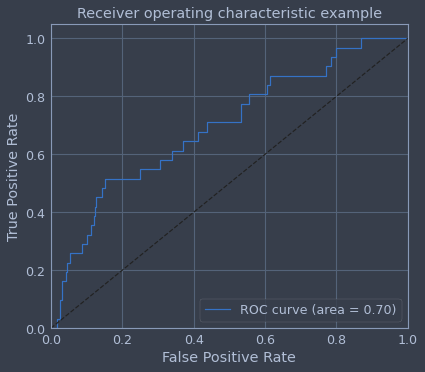

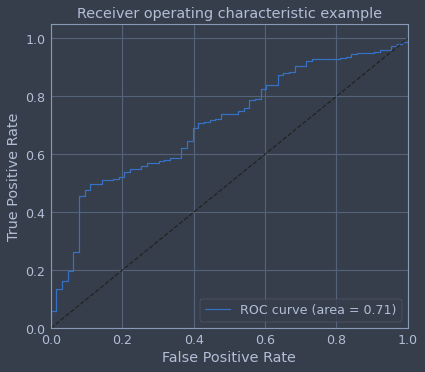

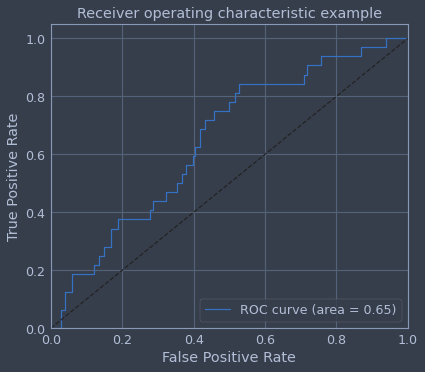

In [39]:
warnings.filterwarnings("default")

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold, mutual_info_classif, SelectFpr, SelectFdr, SelectFwe,RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, QuantileTransformer, MinMaxScaler, label_binarize
from sklearn.model_selection import TimeSeriesSplit, StratifiedKFold, ParameterSampler
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, make_scorer, auc
from scipy.stats import spearmanr
import warnings


param_grid = {
    'feature_selection__k': np.arange(1, 50),
    'classifier__l1_ratio': np.arange(11) / 10,
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__class_weight': [None, 'balanced'],
    'classifier__max_iter': [100, 1000]
}

scorer = make_scorer(roc_auc_score, needs_proba=True, **{'multi_class':'ovo'})

model = Pipeline([
    ("threshold", VarianceThreshold()),
    ("scaler", StandardScaler()),
    ("feature_selection", SelectKBest(f_classif, k=15)),
#     ("classifier", RFECV(LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.1), scoring=scorer)),
#     ("classifier", RFECV(DecisionTreeClassifier(class_weight='balanced', max_depth=3), scoring=scorer)),
#     ("classifier", LogisticRegressionCV(class_weight='balanced', solver='liblinear', penalty='l2', Cs=10, scoring=scorer))
    ("classifier", LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2', C=.01))
])

X = X_features.values[1:]
# y = y[1:] - y[:-1] + 1
# y = y


data_predictions = []
data_probs = []
data_labels = []
splitter = TimeSeriesSplit()

for i, (train_index, test_index) in enumerate(splitter.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    data_predictions.extend(predictions)
    probs = model.predict_proba(X_test)#[:, 1]
    data_probs.extend(probs)
    data_labels.extend(y_test)

data_predictions = np.array(data_predictions)
data_probs = np.array(data_probs)
data_labels = np.array(data_labels)
report = classification_report(data_labels, data_predictions)
print(report)

binned_labels = label_binarize(data_labels, classes=[0,1,2])

n_classes = binned_labels.shape[1]
data_probs = data_probs.reshape(-1, n_classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binned_labels[:, i], data_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

# roc = roc_auc_score(data_labels, data_probs, multi_class='ovr')
# fpr, tpr, _ = roc_curve(data_labels, data_probs)
# fig, ax = plt.subplots(1,1, constrained_layout=True)
# ax.plot(fpr, tpr)
# ax.set_title(f'RoC Score: {roc}')
# ax.set_xlabel('fpr')
# ax.set_ylabel('tpr')
# plt.show()

In [32]:
selected_features = X_features.columns
selected_features = selected_features[model[0].get_support()]
selected_data = model[1].transform(X_features[selected_features].values)
selected_data = pd.DataFrame(selected_data, columns=selected_features)
selected_features = selected_features[model[2].get_support()]
selected_data = selected_data[selected_features]

<AxesSubplot:title={'center':'Feature Importance'}>

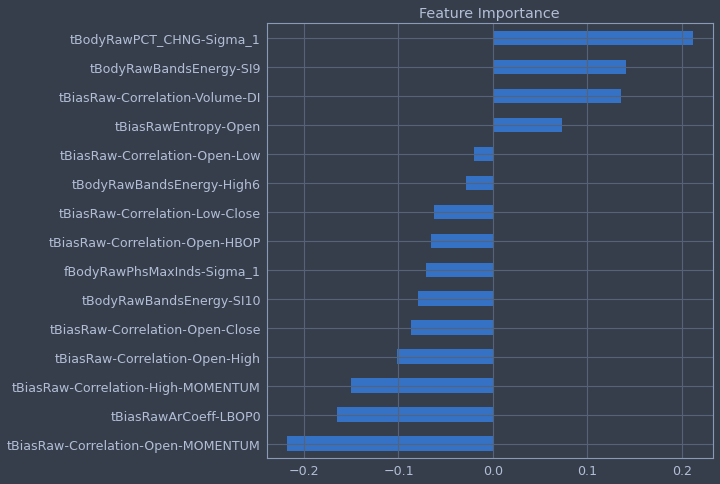

In [33]:
feature_importance = model[-1].coef_[0] * selected_data.std(axis=0)
feature_importance = feature_importance[feature_importance != 0.0]
feature_importance.sort_values(inplace=True)
feature_importance.plot(kind='barh', title='Feature Importance', figsize=(8,8))

In [328]:
from dtreeviz.trees import dtreeviz
import seaborn as sns
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
# sns.set()
# jtplot.style()

viz = dtreeviz(model[-1].estimator_, selected_data.loc[test_index], y[test_index],
               target_name="target",
               feature_names=selected_features,
               class_names=['fall', 'same', 'rise'],
#                colors={'axis_label': 'white',
#                        'title': 'white',
#                        'text': 'white',
#                        'node_label': 'white',
#                        'tick_label': 'white',
#                        'leaf_label': 'white',
#                        'split_line': 'white',
#                        'wedge': 'white',
#                        'text_wedge': 'white',
#                        'legend_title': 'white'}
              )

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 0 1 1 1 1 2 1 0 1 1 2 0 2 1 1 1 0 1 1 2 0 1 2 0 1 1 1 1 2 1 0 2 1 0 2 0
 1 1 1 2 0 1 2 1 0 2 1 1 1 1 0 2 0 1 1 2 1 1 1 0 1 2 0 1 1 1 1 1 2 0 2 1 1
 0 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


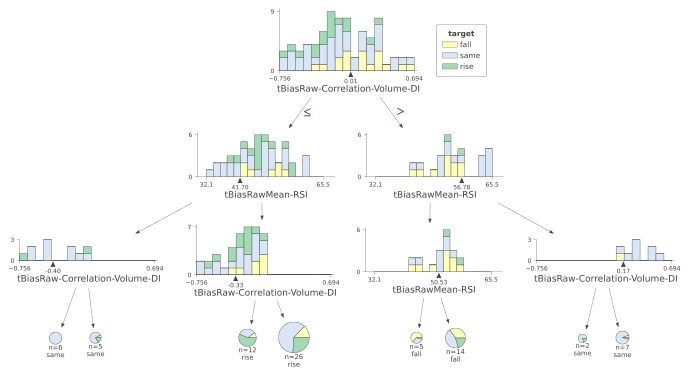

In [329]:
from IPython.display import display

display(viz)

In [299]:
viz.save('test.svg')

In [330]:
print(f'Model bias: {np.mean(np.argmax(data_probs, axis=1)) - np.mean(data_labels)}')

Model bias: 0.2597402597402597


In [40]:
dump(model, 'saved_models/classification_model_BTC_v7.joblib')

['saved_models/classification_model_BTC_v7.joblib']

In [34]:
import functools
import operator
import datetime

def avg_datetime(series):
    dt_min = series.min().values
    deltas = [x-dt_min for x in series.values.astype('datetime64[ns]')]
    return dt_min + functools.reduce(operator.add, deltas) / len(deltas)

preprocessor = Preprocess(fs=1, seg_window=12*24)
_, dates = preprocessor.partition_time_series(signal=pd.DataFrame(data.index),
                                           window_length=12*24,
                                           label_length=12*4,
                                           stride=12*4,
                                           subsample_factor= 1,
                                           binary_delta_labels= False,
                                           binary_delta_value= 'Close')
plot_ticks = np.array([avg_datetime(i) for i in dates]).flatten()[:-1]

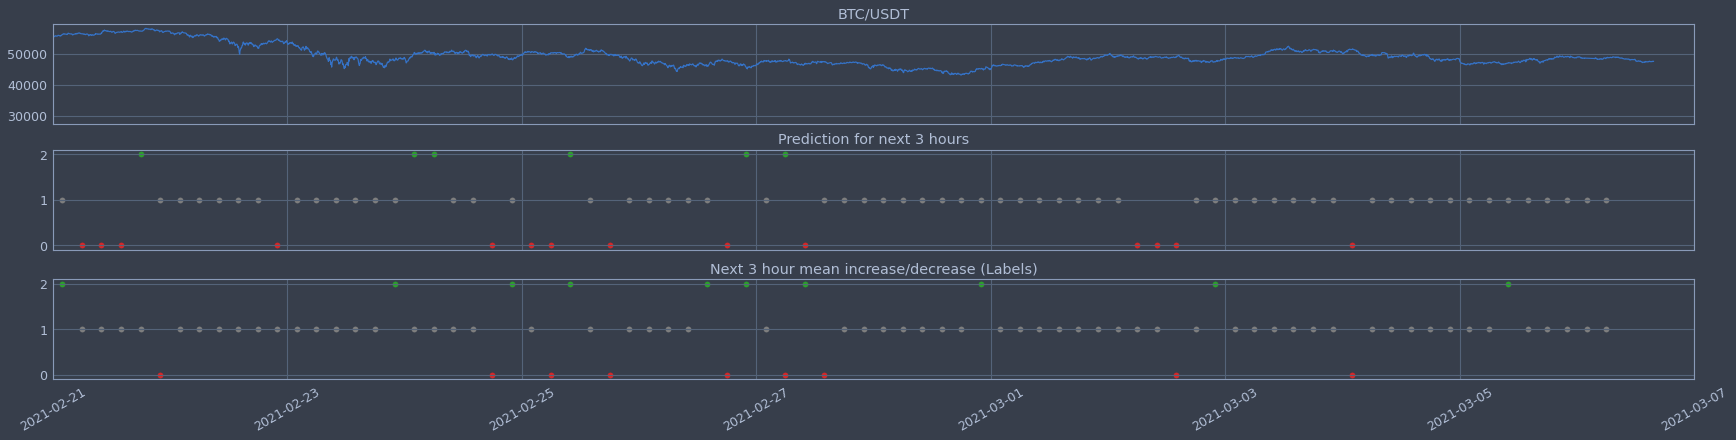

In [35]:
jtplot.style()
data_probs_class = np.argmax(data_probs, axis=1)
fig, ax = plt.subplots(3, 1, figsize=(24,6), constrained_layout=True, sharex=True)
ax[0].plot(np.exp(data['Close'])-1)
ax[0].set_title('BTC/USDT')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 2], data_probs_class[data_probs_class == 2], c='tab:green')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 0], data_probs_class[data_probs_class == 0], c='tab:red')
ax[1].scatter(plot_ticks[len(plot_ticks)-len(data_probs_class):][data_probs_class == 1], data_probs_class[data_probs_class == 1], c='tab:grey')
ax[1].set_title('Prediction for next 3 hours')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 2], data_labels[data_labels == 2], c='tab:green')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 0], data_labels[data_labels == 0], c='tab:red')
ax[2].scatter(plot_ticks[len(plot_ticks)-len(data_labels):][data_labels == 1], data_labels[data_labels == 1], c='tab:gray')
ax[2].set_title('Next 3 hour mean increase/decrease (Labels)')
plt.gca().xaxis.set_tick_params(rotation = 30)
plt.gca().set_xbound('2021-02-21', '2021-03-07')
plt.show()

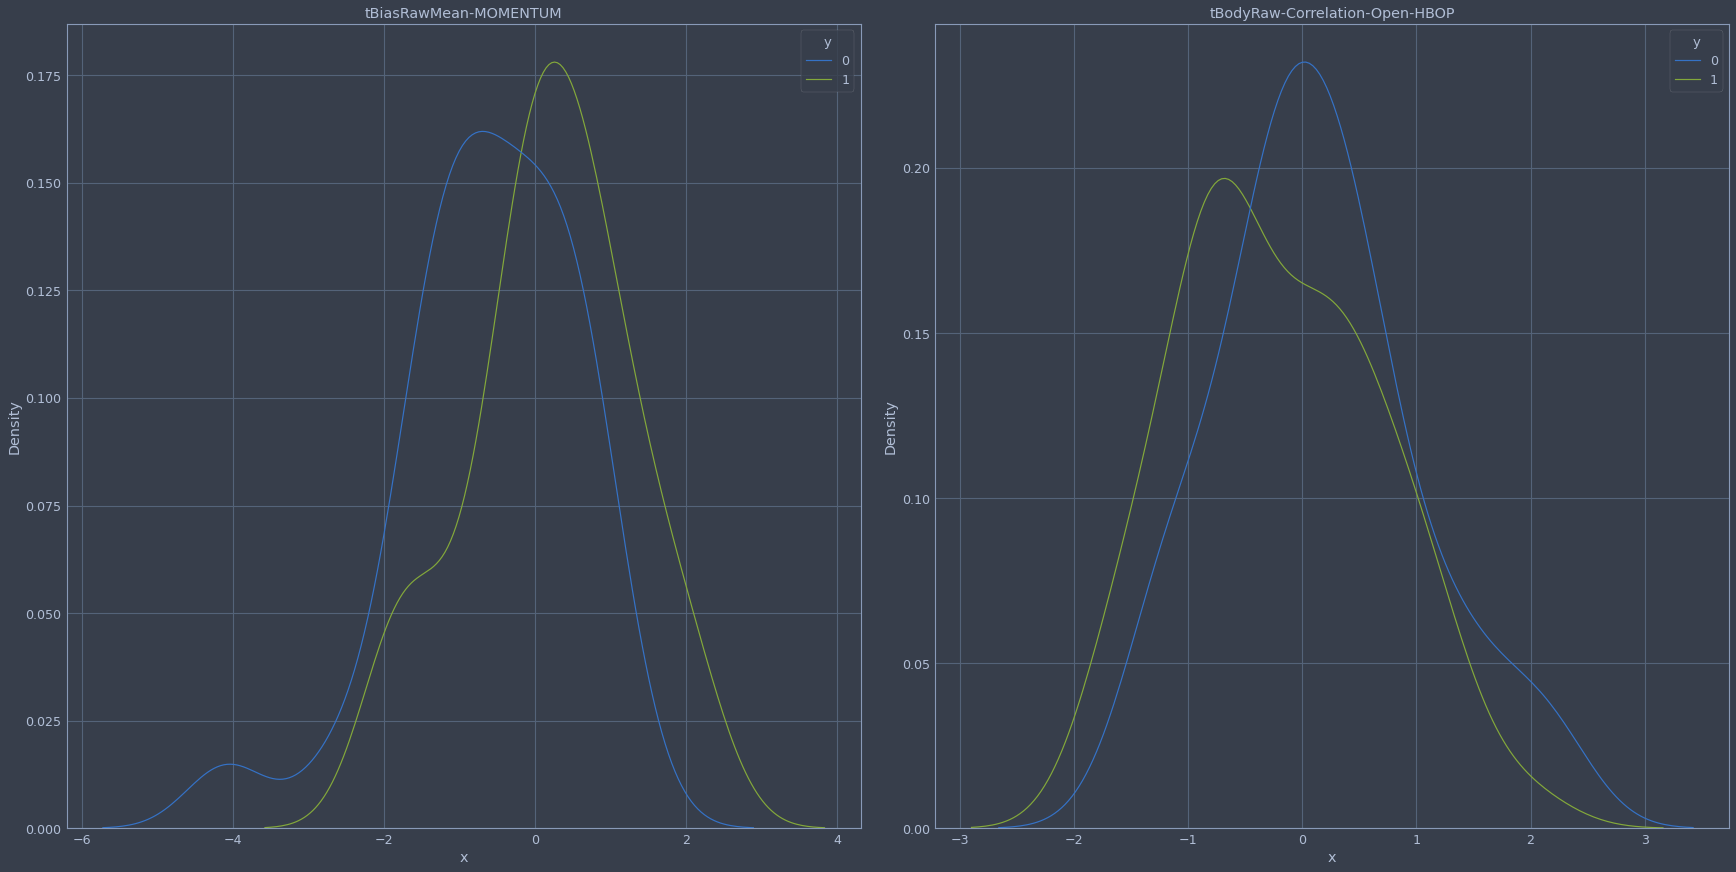

In [66]:
from seaborn import kdeplot

num_rows = int(np.floor(np.sqrt(len(feature_importance.index.tolist()))+0.5))
num_cols = int(np.ceil(np.sqrt(len(feature_importance.index.tolist()))))

fig, ax = plt.subplots(num_rows, num_cols, figsize=(24,12), constrained_layout=True)
ax = np.ravel(ax)
for i, c_name in enumerate(feature_importance.index.tolist()[::-1]):

    x_plot = selected_data[c_name].values[len(plot_ticks)-len(data_labels)+1:]
    y_plot = data_labels

    xy_plot = pd.DataFrame({
        'x': x_plot,
        'y': y_plot
    })
    kdeplot(data=xy_plot, x='x', ax=ax[i], hue='y')
    ax[i].set_title(c_name)
plt.show()